# Developing an AI application to classify grism extractions 

This notebook works through 5 classifications of HST/WFC3 G102 grism emission line extractions: stellar/neighbor contamination, edge of chip, compact, diffuse/low SN, and noisy.  This  will train a neural net (NN) on a subset of images processed with grizli. The extractions have been cropped into individual postage stamps with crop_extractions.py. 

This uses the vgg16 model, which has certain specifications. A list of the models can be found here https://pytorch.org/docs/stable/torchvision/models.html_.

The project is broken down into multiple steps:
1. Load and preprocess the image dataset
2. Train the image classifier on your dataset
3. Use the trained classifier to predict image content


In [114]:
# Imports here
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import os
import matplotlib.pyplot as plt

import torch
import numpy as np
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from PIL import Image
from collections import OrderedDict
import json

# Load the data

The dataset is split into three parts, training, validation, and testing. For the training, you'll want to apply transformations such as random scaling, cropping, and flipping (done below). This will help the network generalize leading to better performance. You'll also need to make sure the input data is resized to 224x224 pixels as required by the pre-trained networks. This should be at least 100 images in a format such as .jpg or .png.

The validation and testing sets are used to measure the model's performance on data it hasn't seen yet. For this you don't want any scaling or rotation transformations, but you'll need to resize then crop the images to the appropriate size.

The pre-trained networks you'll use were trained on the ImageNet dataset where each color channel was normalized separately. For all three sets you'll need to normalize the means and standard deviations of the images to what the network expects. For the means, it's [0.485, 0.456, 0.406] and for the standard deviations [0.229, 0.224, 0.225], calculated from the ImageNet images. These values will shift each color channel to be centered at 0 and range from -1 to 1.

In [115]:
os.getcwd()
!pwd
#list your directories and to each dataset
data_dir = '/Users/jennifercooper/Projects/thesis/23.3_mag/all/Extractions/images/PyTorch_Morphology'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/validate'
test_dir = data_dir + '/test'
#if running on gpu, uncomment. Otherwise, this will be run on cpu.
#using_gpu = torch.cuda.is_available() 


/Users/jennifercooper/Projects/thesis/23.3_mag/all/Extractions/images


In [131]:
#Define your transforms for the training, validation, and testing sets
#rotations, crop to specified length of side of square
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406], 
                                                            [0.229, 0.224, 0.225])])
testval_transforms = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406], 
                                                           [0.229, 0.224, 0.225])])

# Load the datasets with ImageFolder
image_trainset = datasets.ImageFolder(train_dir, transform=train_transforms)
image_testset = datasets.ImageFolder(test_dir, transform=testval_transforms)
image_valset = datasets.ImageFolder(valid_dir, transform=testval_transforms)

#Using the image datasets and the trainforms, define the dataloaders.a higher 
#          batch size processes faster but requires more memory. With 8GB, 16 would be
#          more manageable so that the computer can still be used while it's training
image_trainloader = torch.utils.data.DataLoader(image_trainset, batch_size=16, shuffle=True)
image_testloader = torch.utils.data.DataLoader(image_testset, batch_size=16, shuffle=True)
image_valloader = torch.utils.data.DataLoader(image_valset, batch_size=16, shuffle=True)

In [117]:
#this file lists the classes and their folder location
with open('/Users/jennifercooper/Projects/thesis/23.3_mag/all/Extractions/images/PyTorch_Morphology/grism_classifier.json', 'r') as f:
    cat_to_name = json.load(f)

# Building and training the classifier
Now that the data is ready, it's time to build and train the classifier. As usual, you should use one of the pretrained models from torchvision.models to get the image features. Build and train a new feed-forward classifier using those features.

1. Load a pre-trained network -  I am using vgg16 here. 
2. Define a new, untrained feed-forward network as a classifier, using Rectified Linear Unit (ReLU) activations and dropout. In a NN, the activation function is responsible for transforming the summed weighted input from the node into the activation of the node or output for that input. The ReLU is a piecewise linear function that will output the input directly if is positive, otherwise, it will output zero. It has become the default activation function for many types of neural networks because a model that uses it is easier to train and often achieves better performance.
3. Train the classifier layers using backpropagation using the pre-trained network to get the features. An epoch represents one cycle of training on the dataset and takes approximately 25 minutes per epoch to complete on a 2.6 GHz Intel Core i5 Macbook with 8 GB of memory. 
4. Track the loss and accuracy on the validation set to determine the best hyperparameters. Your accuracy should be higher than random chance, and values aboe 70% are considered good. 



In [118]:
#Build and train your network
epochs = 20 #how many cycles to train on
lr = 0.001 #learning rate, this is the default value in a class
print_every = 10

In [119]:
# Freeze parameters so we don't backprop through them
hidden_layers = [10, 10] #private to the NN; higher numbers can solve more complex problems but require more time to produce the output, doesn't have to be this high
def make_model(structure, hidden_layers, lr):
    if structure=="densenet161": #this is for another model
        model = models.densenet161(pretrained=True)
        input_size = 2208
    else:
        model = models.vgg16(pretrained=True) #current model
        input_size = 25088
    output_size =  4                         #number of classes
    for param in model.parameters():
        param.requires_grad = False

    classifier = nn.Sequential(OrderedDict([
                              ('dropout',nn.Dropout(0.5)),
                              ('fc1', nn.Linear(input_size, hidden_layers[0])),
                              ('relu1', nn.ReLU()),
                              ('fc2', nn.Linear(hidden_layers[0], hidden_layers[1])),
                              ('relu2', nn.ReLU()),
                              ('fc3', nn.Linear(hidden_layers[1], output_size)),
                              ('output', nn.LogSoftmax(dim=1))
                              ]))

    model.classifier = classifier
    return model

model = make_model('vgg16', hidden_layers, lr)

In [120]:
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=lr)

In [121]:
def cal_accuracy(model, dataloader):
    validation_loss = 0
    accuracy = 0
    for i, (inputs,labels) in enumerate(dataloader):
                optimizer.zero_grad()
                inputs, labels = inputs.to('cpu') , labels.to('cpu')
                model.to('cpu')
                with torch.no_grad():    
                    outputs = model.forward(inputs)
                    validation_loss = criterion(outputs,labels)
                    ps = torch.exp(outputs).data
                    equality = (labels.data == ps.max(1)[1])
                    accuracy += equality.type_as(torch.FloatTensor()).mean()
                    
    validation_loss = validation_loss / len(dataloader)
    accuracy = accuracy /len(dataloader)
    
    return validation_loss, accuracy

In [122]:
#this will start training the network; grism classifier took approximately 2 hours to run this cell
    def my_DLM(model, image_trainloader, image_valloader, epochs, print_every, criterion, optimizer, device='cpu'):
        epochs = epochs
        print_every = print_every
        steps = 0
        model.to('cpu')

        for e in range(epochs):
            running_loss = 0
            for ii, (inputs, labels) in enumerate(image_trainloader):
                steps += 1

                inputs, labels = inputs.to('cpu'), labels.to('cpu')

                optimizer.zero_grad()

                # Forward and backward passes
                outputs = model.forward(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                running_loss += loss.item()

                if steps % print_every == 0:
                    model.eval()
                    val_loss, train_ac = cal_accuracy(model, image_valloader)
                    print("Epoch: {}/{}... | ".format(e+1, epochs),
                          "Loss: {:.4f} | ".format(running_loss/print_every),
                          "Validation Loss {:.4f} | ".format(val_loss),
                          "Accuracy {:.4f}".format(train_ac))

                    running_loss = 0
    my_DLM(model, image_trainloader, image_valloader, epochs, print_every, criterion, optimizer, 'cpu')

Epoch: 1/20... |  Loss: 1.3818 |  Validation Loss 0.0478 |  Accuracy 0.3204
Epoch: 1/20... |  Loss: 1.3225 |  Validation Loss 0.0628 |  Accuracy 0.6599
Epoch: 1/20... |  Loss: 1.1906 |  Validation Loss 0.0980 |  Accuracy 0.6197
Epoch: 1/20... |  Loss: 1.0698 |  Validation Loss 0.0464 |  Accuracy 0.6474
Epoch: 2/20... |  Loss: 0.3965 |  Validation Loss 0.0585 |  Accuracy 0.6329
Epoch: 2/20... |  Loss: 0.8958 |  Validation Loss 0.0359 |  Accuracy 0.6441
Epoch: 2/20... |  Loss: 0.9052 |  Validation Loss 0.0148 |  Accuracy 0.6447
Epoch: 2/20... |  Loss: 0.8920 |  Validation Loss 0.0370 |  Accuracy 0.6336
Epoch: 2/20... |  Loss: 0.8300 |  Validation Loss 0.0791 |  Accuracy 0.6296
Epoch: 3/20... |  Loss: 0.6098 |  Validation Loss 0.0427 |  Accuracy 0.6336
Epoch: 3/20... |  Loss: 0.7335 |  Validation Loss 0.0057 |  Accuracy 0.6678
Epoch: 3/20... |  Loss: 0.8393 |  Validation Loss 0.1023 |  Accuracy 0.6421
Epoch: 3/20... |  Loss: 0.9920 |  Validation Loss 0.0167 |  Accuracy 0.6612
Epoch: 4/20.

In [132]:
#Validation on the test set
def testing(dataloader):
    model.eval()
    model.to('cpu')
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in image_testloader:
            inputs, labels = inputs.to('cpu'), labels.to('cpu')
            outputs = model(inputs)
            _ , prediction = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (prediction == labels.data).sum().item()
        print('Accuracy on the test set: %d %%' % (100 * correct / total))   
testing(image_testloader)

Accuracy on the test set: 68 %


In [124]:
model.class_to_idx = image_trainset.class_to_idx
#This saves the NN so it does not have to be recreated. The file size is 1.3 GB.

state = {
            'structure' :'vgg16',
            'learning_rate': lr,
            'epochs': epochs,
            'hidden_layers':hidden_layers,
            'state_dict':model.state_dict(),
            'class_to_idx':model.class_to_idx
}
torch.save(state, 'checkpoint_grism_classifier_16-20_4.pth')

In [125]:
# This reloads the NN
def loading_checkpoint(path):
    
    # Loading the parameters
    state = torch.load(path)
    lr = state['learning_rate']
    structure = state['structure']
    hidden_layers = state['hidden_layers']
    epochs = state['epochs']
    
    # Building the model from checkpoints
    model = make_model(structure, hidden_layers, lr)
    class_to_idx = state['class_to_idx']
    model.load_state_dict(state['state_dict'])
    
loading_checkpoint('checkpoint_grism_classifier_16-20_4.pth') #batch size, epochs, classes

In [126]:
#Scales, crops, and normalizes a Python Image Library(PIL, also known as Pillow) image for a PyTorch model, returns an Numpy array#
def process_image(image):
    pil_image = Image.open(image)
   
    image_transforms = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    img = image_transforms(pil_image)
    return img

In [104]:
#Load the image, outputs the array
##image_path = (test_dir + '/4/' + 'crop1em_j113736m1125_00222.line.png')
##processed_image = Image.open(image_path).convert('RGB')
#plt.imshow(processed_image)
#processed_image = process_image(image_path)
##processed_image

#Load the image, outputs the array
image_path = ('/Users/jennifercooper/Projects/thesis/23.3_mag/all/Extractions/images/single/sample_2.jpg')
processed_image = process_image(image_path)
processed_image


tensor([[[ 2.0948,  2.0948,  2.0948,  ...,  2.0948,  2.1119,  2.1633],
         [ 2.0605,  2.0605,  2.0605,  ...,  2.0263,  2.0434,  2.0777],
         [ 2.0605,  2.0605,  2.0605,  ...,  2.0605,  2.0777,  2.0948],
         ...,
         [ 1.9920,  2.0948,  2.0948,  ...,  2.0605,  2.0605,  2.0605],
         [ 1.9920,  2.0777,  2.1290,  ...,  2.0605,  2.0605,  2.0605],
         [ 2.1804,  2.1975,  2.1290,  ...,  2.0605,  2.0605,  2.0605]],

        [[ 2.0434,  2.0434,  2.0434,  ...,  1.8859,  1.8683,  1.7808],
         [ 2.0609,  2.0609,  2.0609,  ...,  1.9734,  1.9559,  1.8859],
         [ 2.0609,  2.0609,  2.0609,  ...,  2.2535,  2.2535,  2.2010],
         ...,
         [ 2.1134,  2.0609,  1.7808,  ...,  2.0609,  2.0609,  2.0609],
         [ 2.1310,  2.0609,  1.7633,  ...,  2.0609,  2.0609,  2.0609],
         [ 1.8683,  1.8683,  1.7808,  ...,  2.0609,  2.0609,  2.0609]],

        [[-1.3687, -1.3687, -1.3687,  ..., -1.4210, -1.3687, -1.3687],
         [-1.1596, -1.1596, -1.1596,  ..., -1

In [127]:
#Show the image
def imshow(image, ax=None, title=None):
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

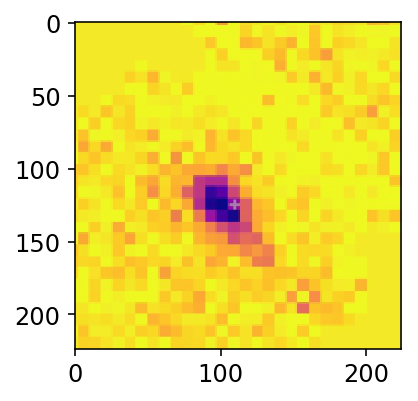

In [106]:
#image_path = (test_dir + '/4/' + 'crop1em_j113736m1125_00222.line.png')
imshow(processed_image.numpy())

In [128]:
#Predict the class (or classes) of an image using a the trained NN. topk is number of classes.
def predict(image_path, model, topk=4):

    model.eval()
    model.cpu()
    img = process_image(image_path)
    img = img.unsqueeze_(0)
    img = img.float()
    
    with torch.no_grad():
        output = model.forward(img)
        probs, classes = torch.topk(input=output, k=topk)
        top_prob = probs.exp()

    # Convert indices to classes
    idx_to_class = {val: key for key, val in model.class_to_idx.items()}
    top_classes = [idx_to_class[each] for each in classes.cpu().numpy()[0]]
        
    print('Top Classes: ', top_classes)
    print('Top Probs: ', top_prob)
    return top_prob, top_classes
    
    

In [108]:
#image_path = (test_dir + '/4/' + 'crop1em_j113736m1125_00222.line.png')
probs, classes = predict(image_path, model)
#probs, classes = predict(image_path, model) original


# Converting from tensor to numpy-array
print(probs)
print(classes)

Top Classes:  ['3', '5', '4', '2', '6']
Top Probs:  tensor([[0.4182, 0.3767, 0.1289, 0.0681, 0.0081]])
tensor([[0.4182, 0.3767, 0.1289, 0.0681, 0.0081]])
['3', '5', '4', '2', '6']


In [111]:
#convert files from 4-channel png (RGBa) to 3-channel jpg (RGB)
    directory = '/Users/jennifercooper/Projects/thesis/23.3_mag/all/Extractions/images/single/'
    for file in os.listdir(directory):
        filename = os.fsdecode(file)
        if filename.endswith(".png"): 
            image_path = (directory + filename)
            rgba_image = Image.open(image_path)
            rgba_image.load()
            background = Image.new("RGB", rgba_image.size, (255, 255, 255))
            background.paste(rgba_image, mask = rgba_image.split()[3])
            background.save(directory + filename +".jpg", "JPEG", quality=100)

Top Classes:  ['6', '3', '4', '5']
Top Probs:  tensor([[0.6185, 0.3070, 0.0711, 0.0035]])


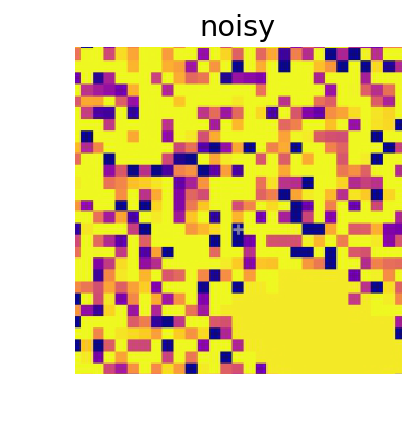

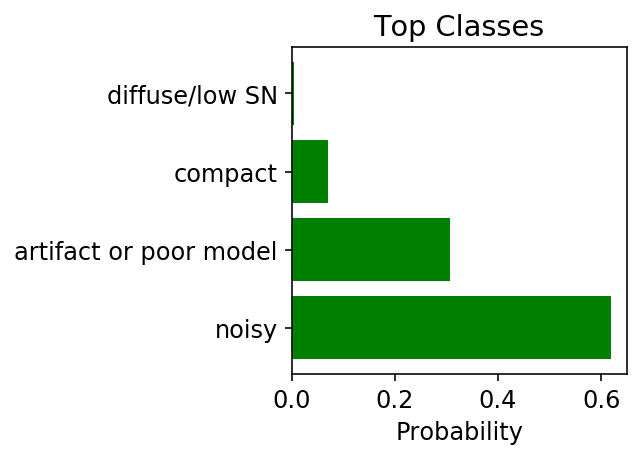

Top Classes:  ['5', '3', '4', '6']
Top Probs:  tensor([[8.0972e-01, 1.1825e-01, 7.1824e-02, 2.0502e-04]])


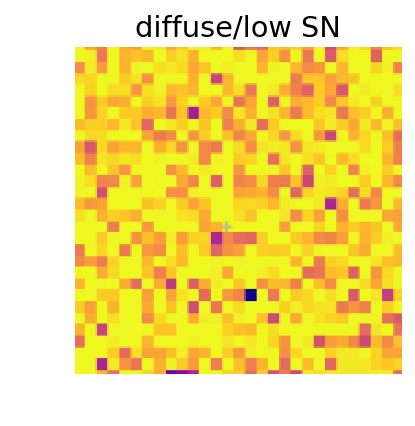

Top Classes:  ['3', '6', '4', '5']
Top Probs:  tensor([[9.0092e-01, 8.5029e-02, 1.3899e-02, 1.4898e-04]])


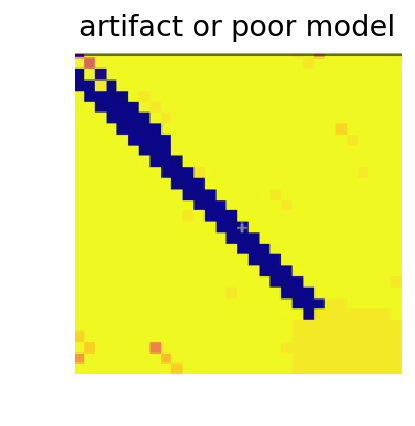

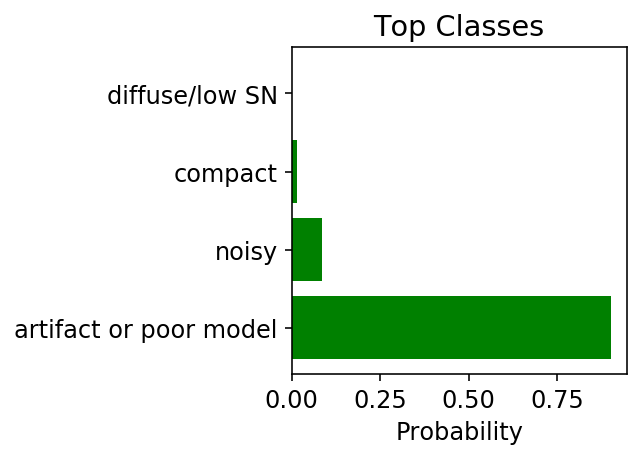

Top Classes:  ['6', '3', '4', '5']
Top Probs:  tensor([[0.8320, 0.1409, 0.0252, 0.0019]])


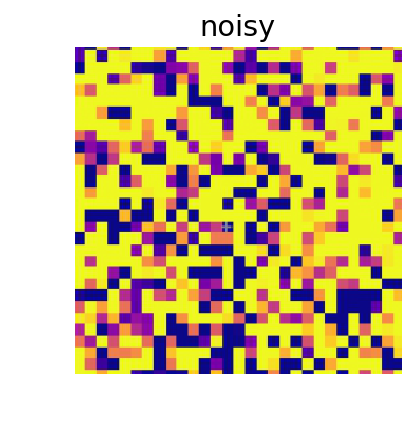

Top Classes:  ['5', '3', '4', '6']
Top Probs:  tensor([[0.5861, 0.2872, 0.1261, 0.0007]])


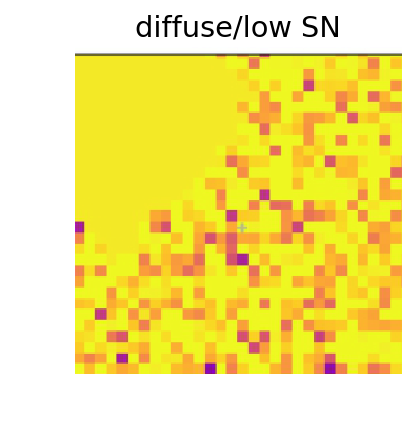

Top Classes:  ['3', '6', '4', '5']
Top Probs:  tensor([[0.5801, 0.2889, 0.1204, 0.0106]])


Top Classes:  ['5', '3', '4', '6']
Top Probs:  tensor([[6.2061e-01, 2.8687e-01, 9.2420e-02, 1.0515e-04]])


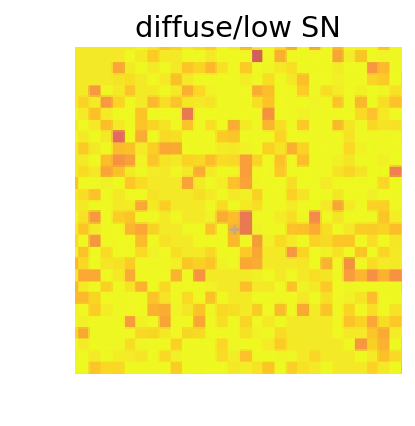

Top Classes:  ['6', '3', '4', '5']
Top Probs:  tensor([[7.2771e-01, 2.6438e-01, 7.4640e-03, 4.4493e-04]])


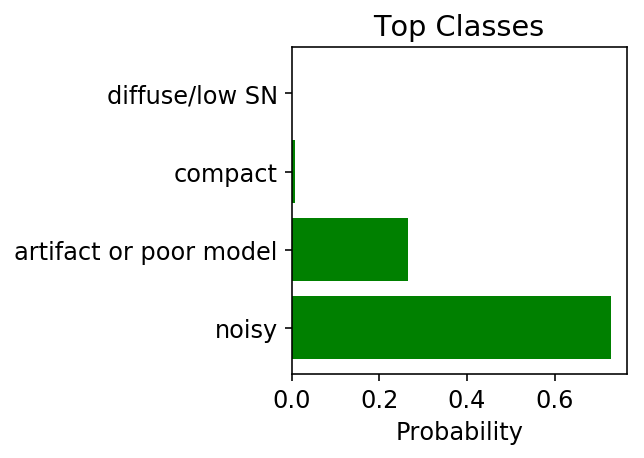

Top Classes:  ['5', '3', '4', '6']
Top Probs:  tensor([[6.6353e-01, 2.4796e-01, 8.8398e-02, 1.1401e-04]])


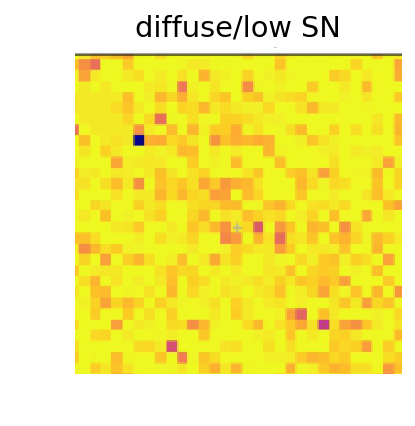

Top Classes:  ['3', '4', '6', '5']
Top Probs:  tensor([[9.7545e-01, 1.2592e-02, 1.1880e-02, 7.6582e-05]])


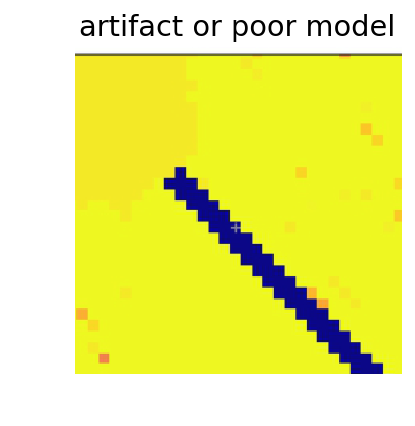

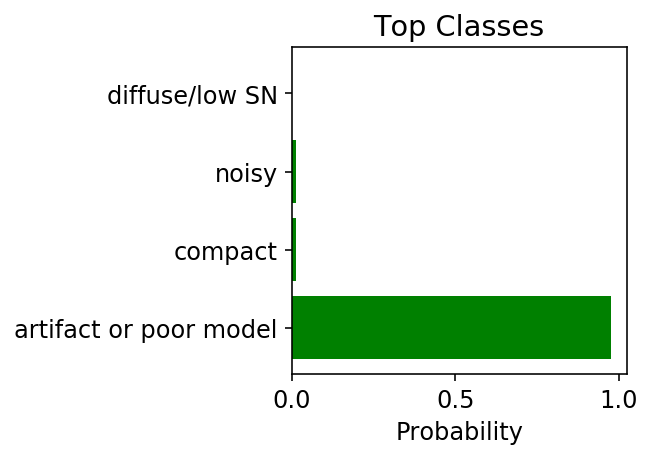

Top Classes:  ['5', '4', '3', '6']
Top Probs:  tensor([[0.6330, 0.1853, 0.1404, 0.0413]])


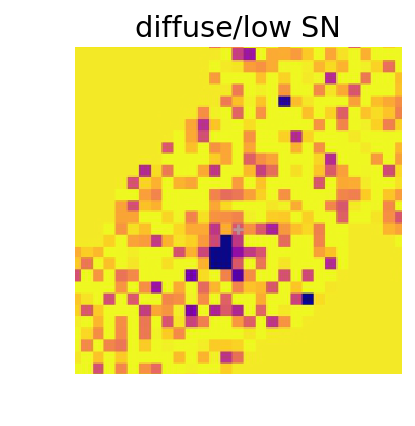

Top Classes:  ['6', '3', '4', '5']
Top Probs:  tensor([[0.5700, 0.2950, 0.1189, 0.0161]])


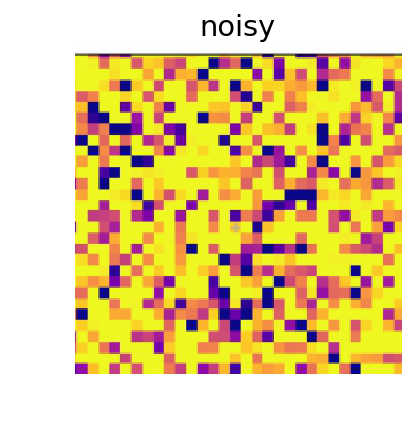

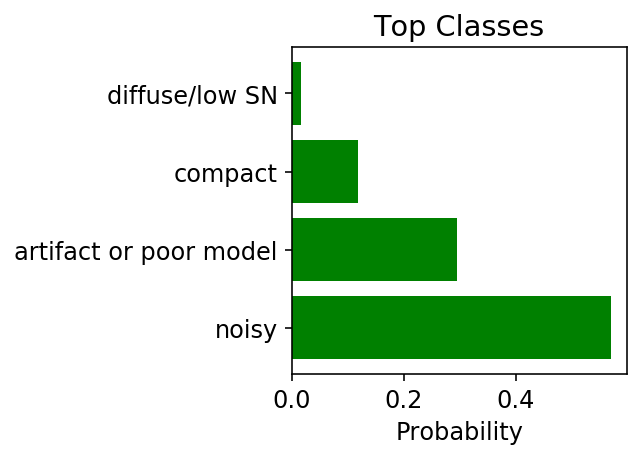

Top Classes:  ['3', '4', '5', '6']
Top Probs:  tensor([[0.8599, 0.1038, 0.0229, 0.0134]])


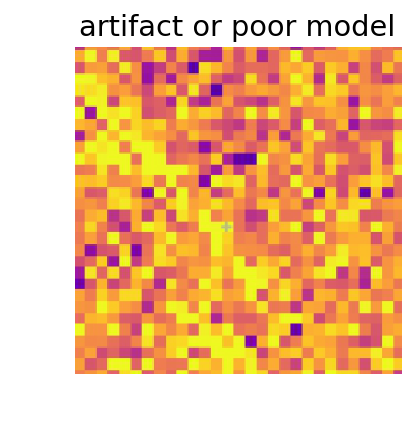

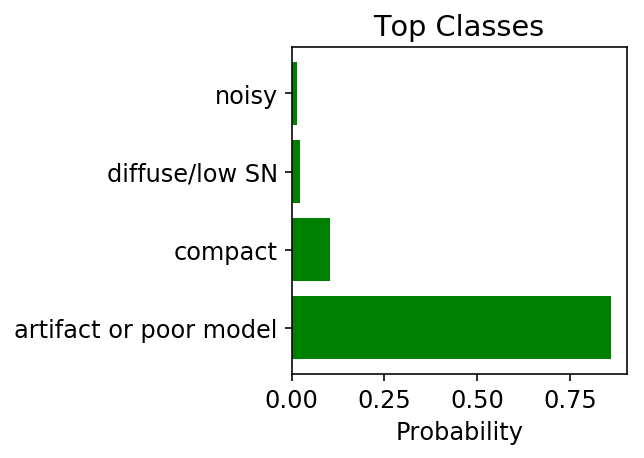

Top Classes:  ['6', '3', '4', '5']
Top Probs:  tensor([[8.3954e-01, 1.5946e-01, 9.3372e-04, 6.9555e-05]])


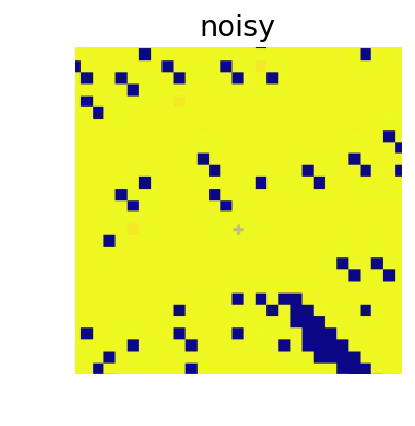

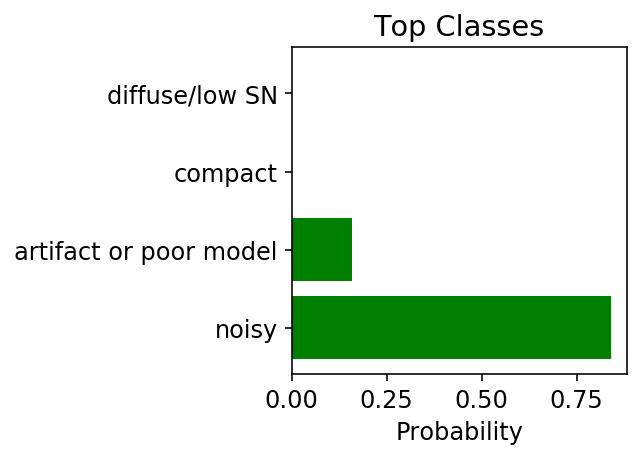

Top Classes:  ['3', '6', '4', '5']
Top Probs:  tensor([[0.4783, 0.3121, 0.1741, 0.0356]])


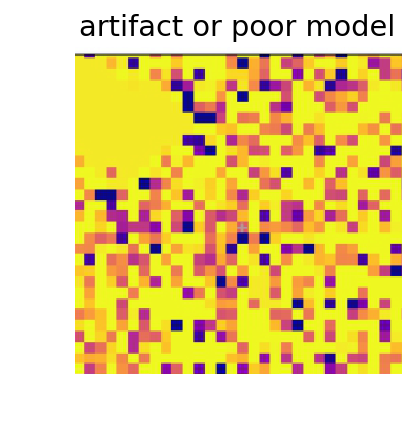

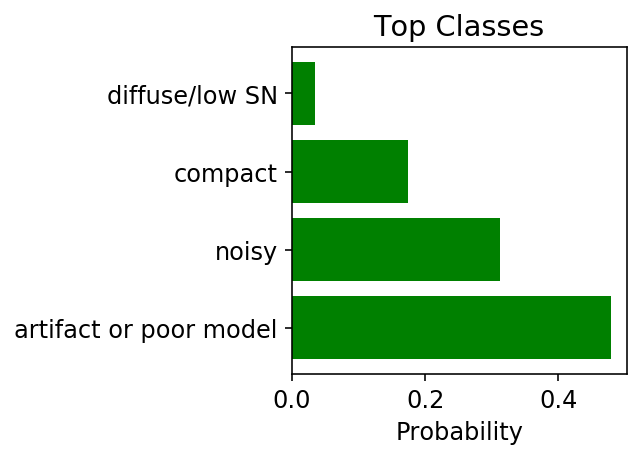

Top Classes:  ['5', '3', '4', '6']
Top Probs:  tensor([[5.6929e-01, 3.1999e-01, 1.1046e-01, 2.6386e-04]])


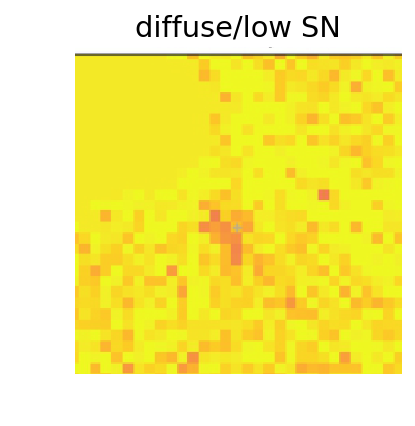

Top Classes:  ['5', '3', '4', '6']
Top Probs:  tensor([[0.5286, 0.3031, 0.1643, 0.0041]])


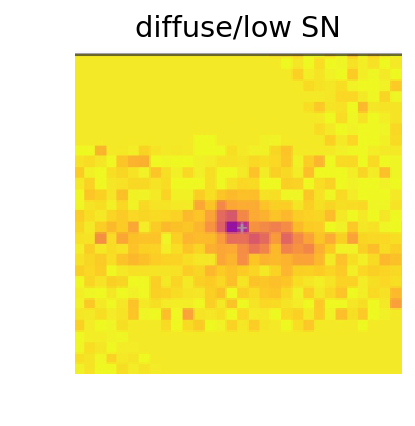

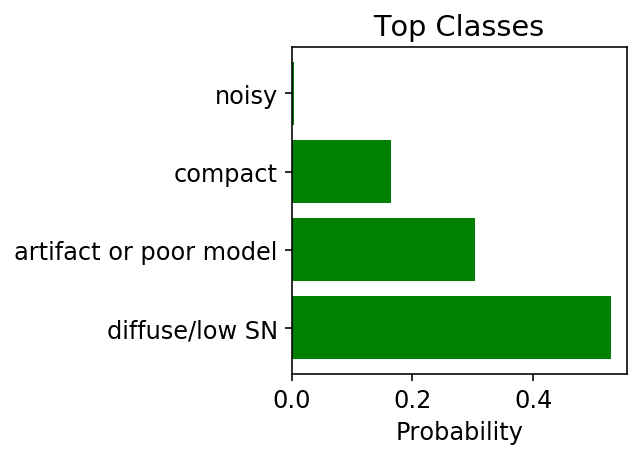

Top Classes:  ['3', '4', '6', '5']
Top Probs:  tensor([[0.6311, 0.2028, 0.0889, 0.0772]])


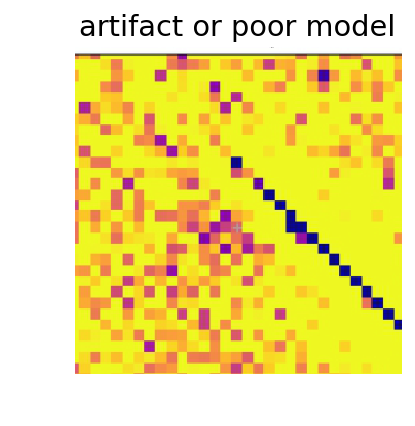

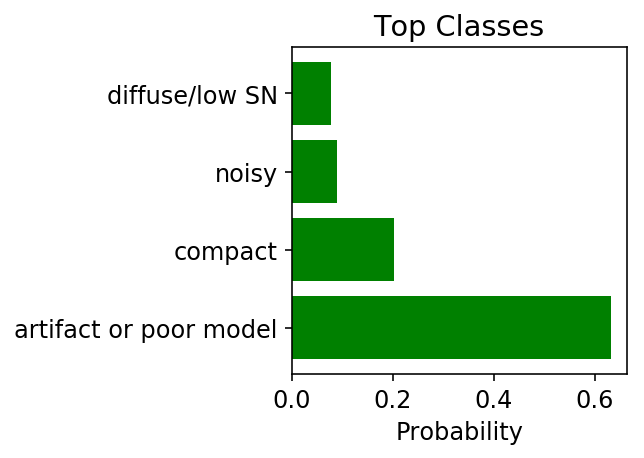

Top Classes:  ['3', '4', '5', '6']
Top Probs:  tensor([[0.5993, 0.2153, 0.0971, 0.0883]])


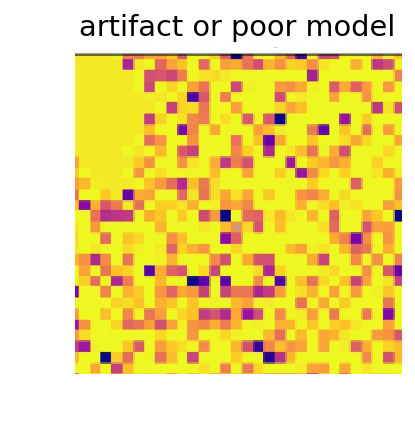

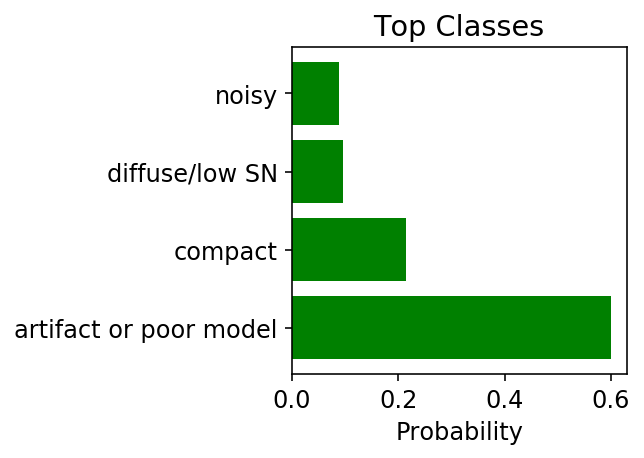

Top Classes:  ['5', '3', '4', '6']
Top Probs:  tensor([[6.1618e-01, 2.8092e-01, 1.0268e-01, 2.2398e-04]])


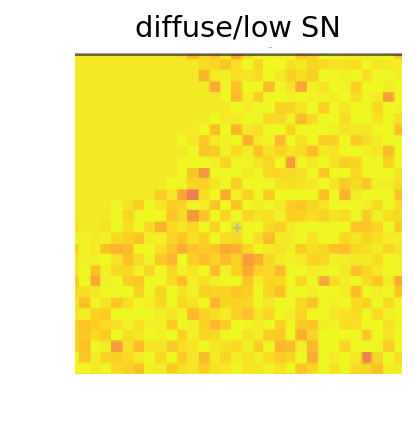

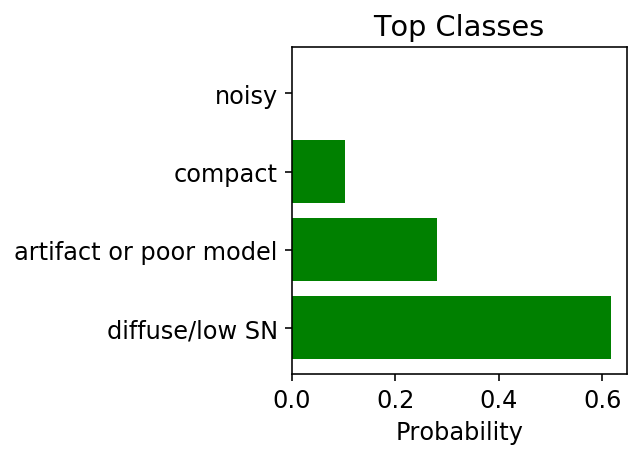

Top Classes:  ['6', '3', '4', '5']
Top Probs:  tensor([[0.5770, 0.2663, 0.1324, 0.0243]])


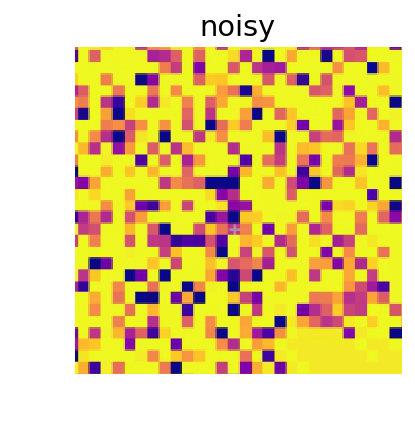

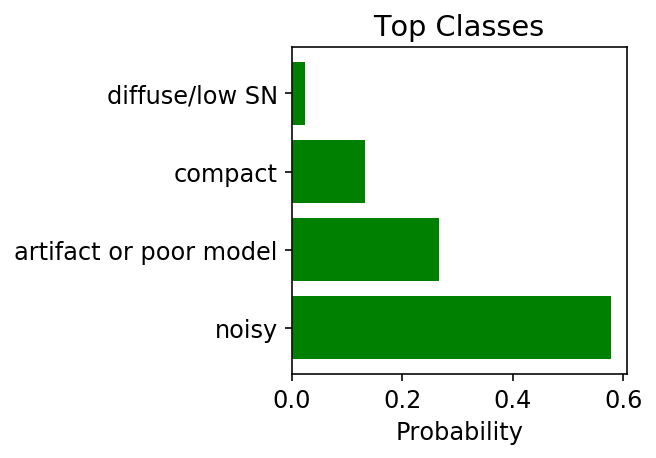

Top Classes:  ['5', '3', '4', '6']
Top Probs:  tensor([[0.5602, 0.2697, 0.1662, 0.0039]])


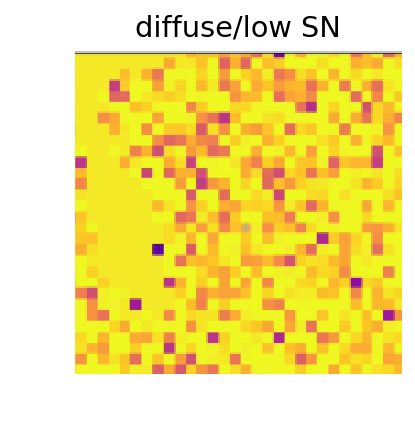

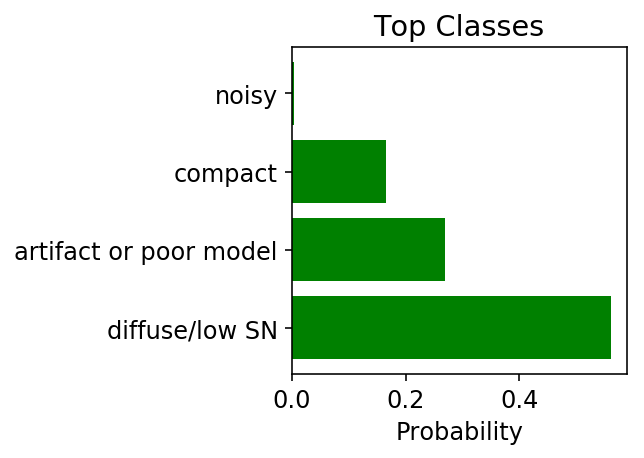

Top Classes:  ['6', '3', '4', '5']
Top Probs:  tensor([[0.8369, 0.1294, 0.0318, 0.0020]])


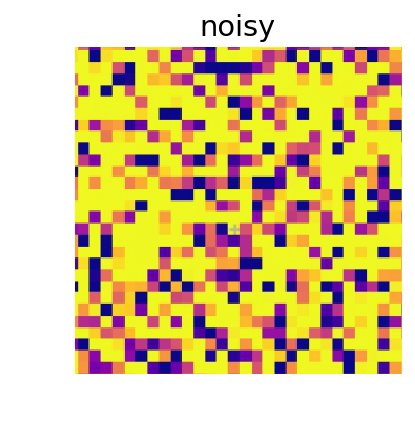

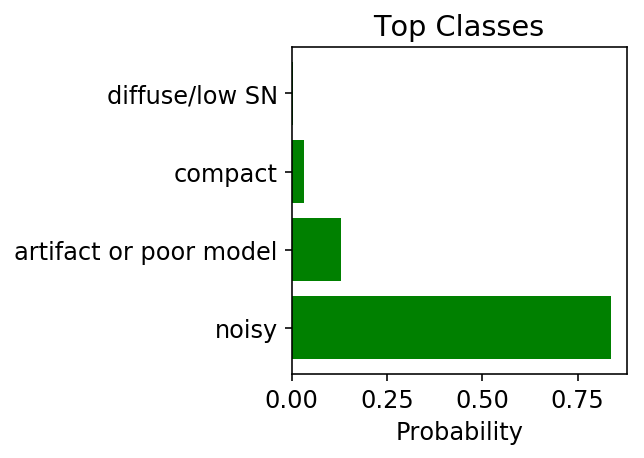

Top Classes:  ['5', '3', '4', '6']
Top Probs:  tensor([[0.7058, 0.1672, 0.1246, 0.0024]])


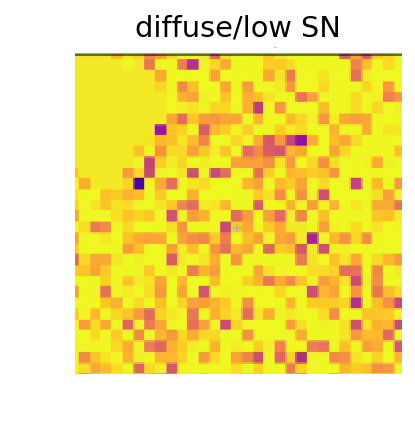

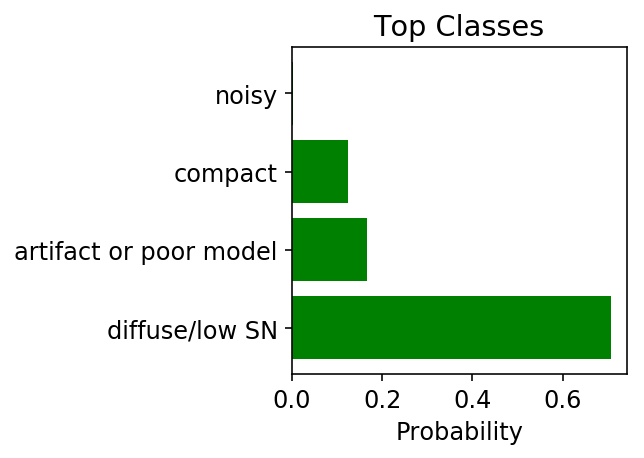

Top Classes:  ['5', '3', '4', '6']
Top Probs:  tensor([[5.9601e-01, 3.0199e-01, 1.0182e-01, 1.7740e-04]])


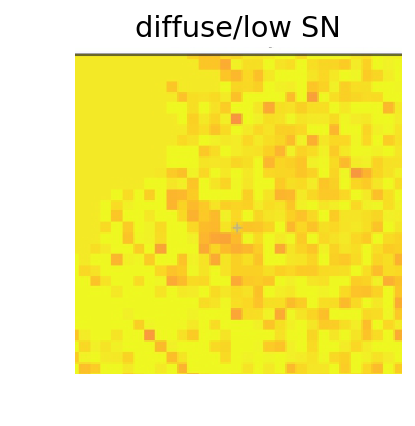

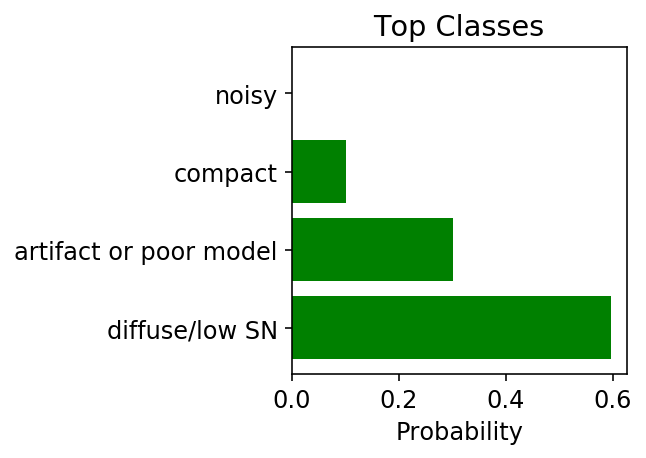

Top Classes:  ['5', '3', '4', '6']
Top Probs:  tensor([[0.4394, 0.3493, 0.2034, 0.0079]])


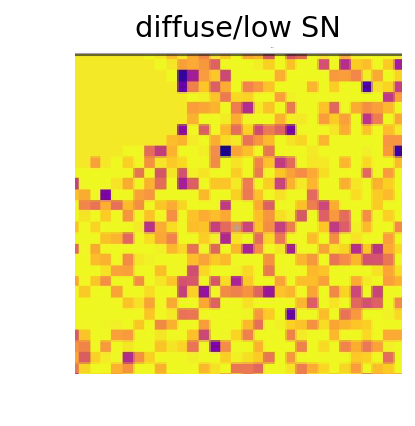

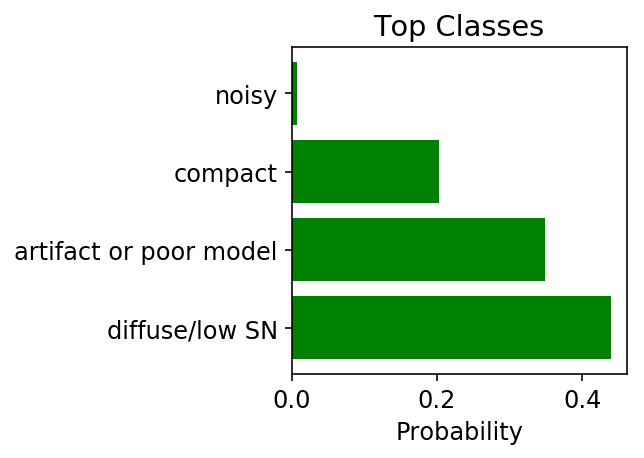

Top Classes:  ['5', '3', '4', '6']
Top Probs:  tensor([[0.5914, 0.2308, 0.1713, 0.0064]])


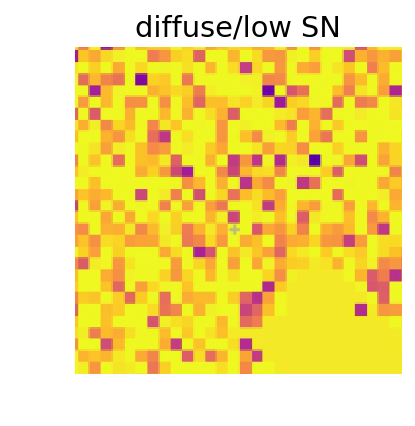

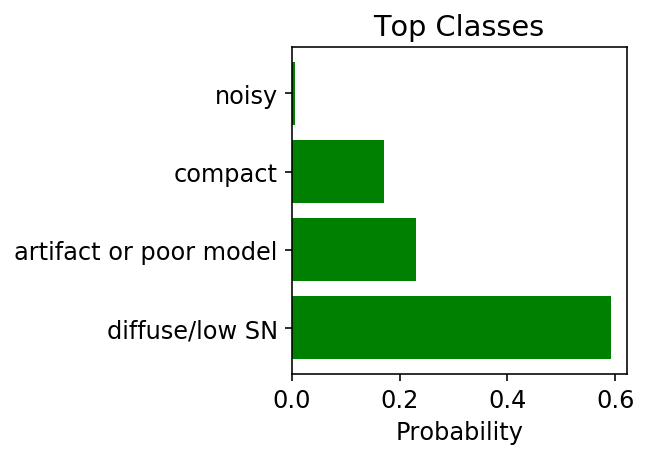

Top Classes:  ['5', '3', '4', '6']
Top Probs:  tensor([[0.7238, 0.1638, 0.1110, 0.0014]])


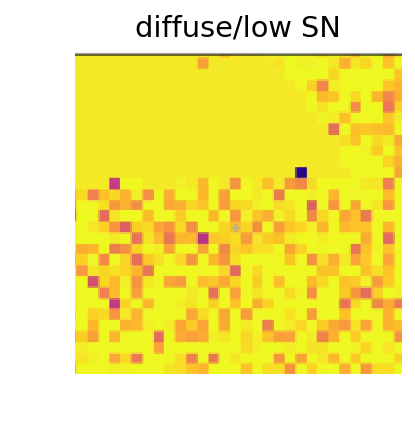

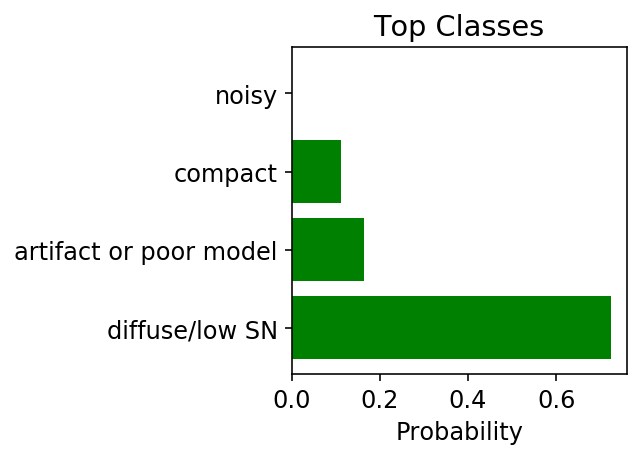

Top Classes:  ['5', '3', '4', '6']
Top Probs:  tensor([[5.8371e-01, 3.3063e-01, 8.5608e-02, 4.8590e-05]])


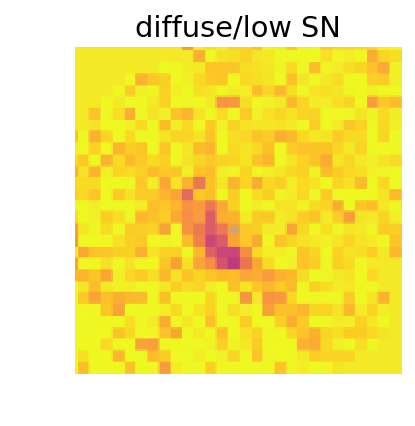

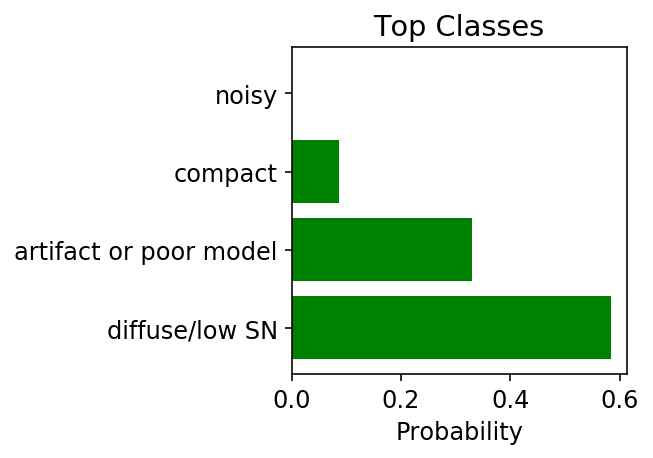

Top Classes:  ['6', '3', '4', '5']
Top Probs:  tensor([[0.9094, 0.0693, 0.0186, 0.0027]])


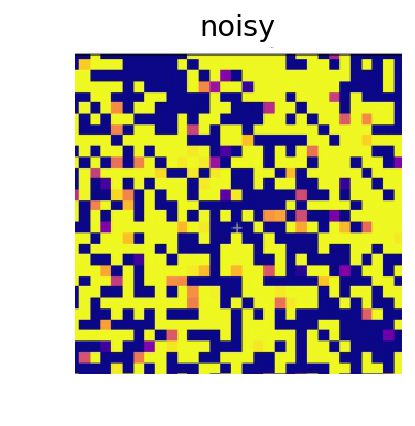

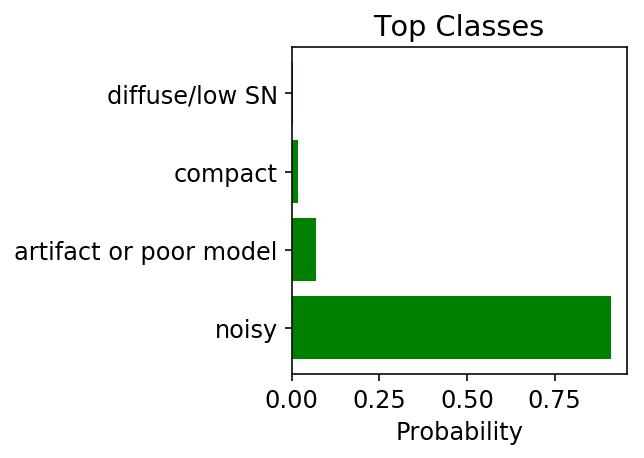

Top Classes:  ['3', '5', '4', '6']
Top Probs:  tensor([[0.3451, 0.3234, 0.2542, 0.0773]])


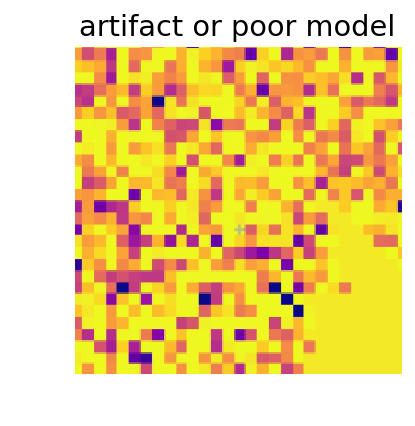

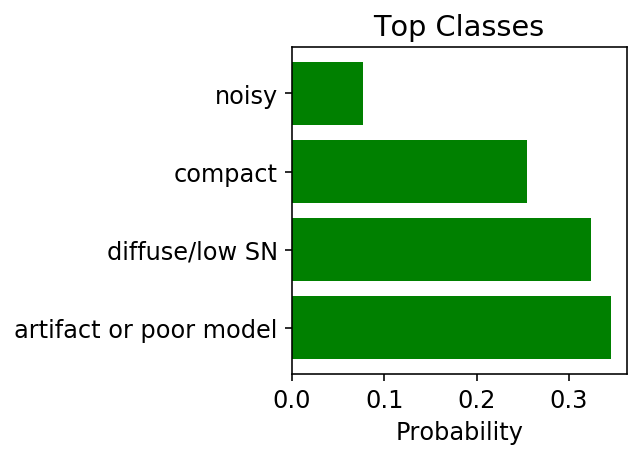

Top Classes:  ['5', '4', '3', '6']
Top Probs:  tensor([[0.8194, 0.0936, 0.0839, 0.0031]])


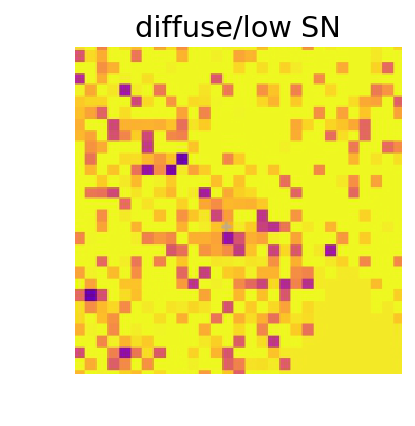

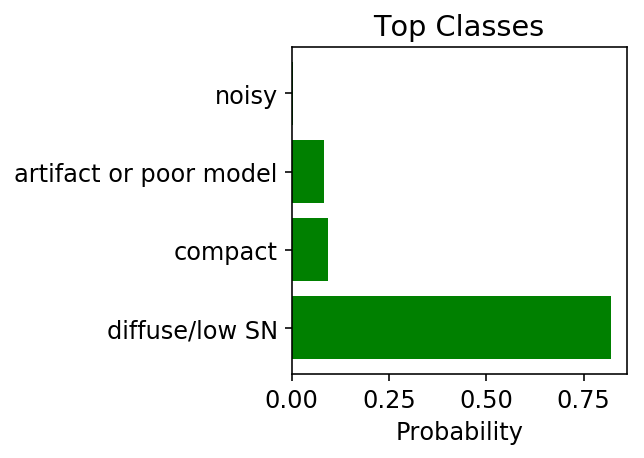

Top Classes:  ['3', '5', '4', '6']
Top Probs:  tensor([[4.8656e-01, 4.1997e-01, 9.3424e-02, 4.2842e-05]])


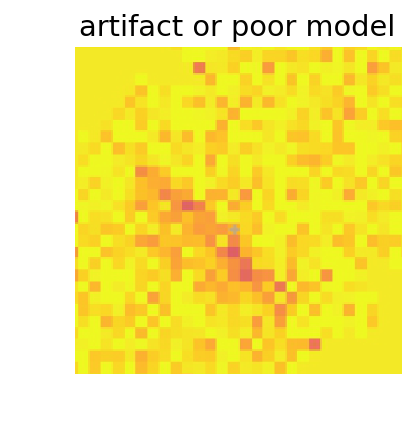

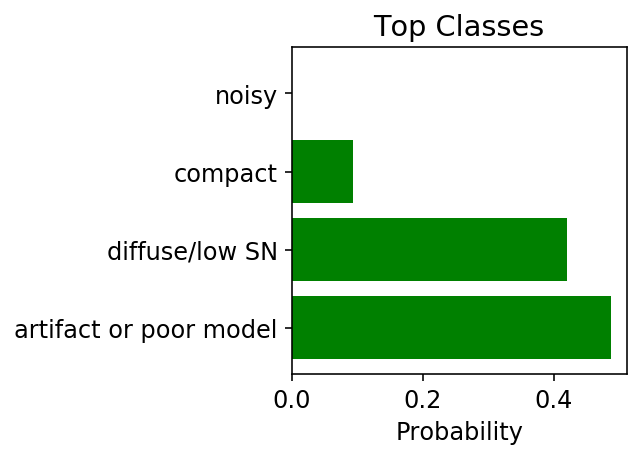

Top Classes:  ['3', '4', '6', '5']
Top Probs:  tensor([[0.6910, 0.1634, 0.1125, 0.0330]])


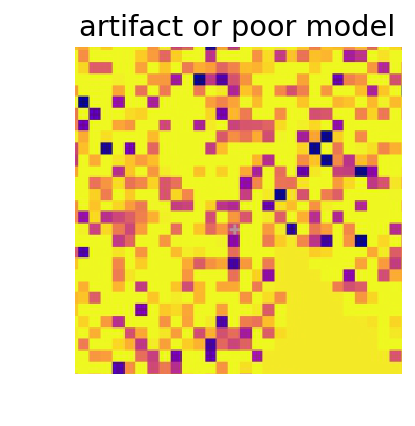

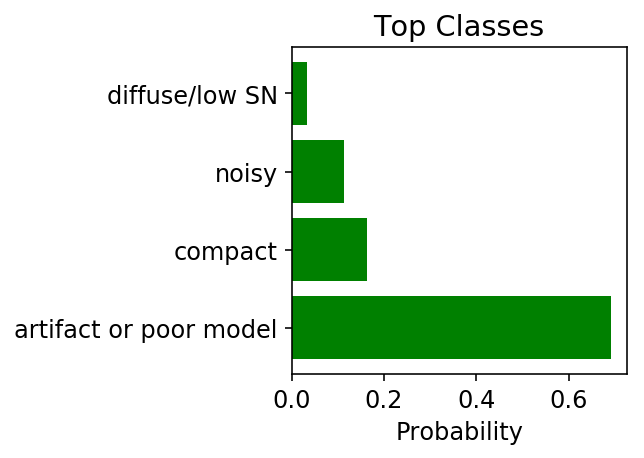

Top Classes:  ['5', '3', '4', '6']
Top Probs:  tensor([[6.7093e-01, 2.2011e-01, 1.0837e-01, 5.9777e-04]])


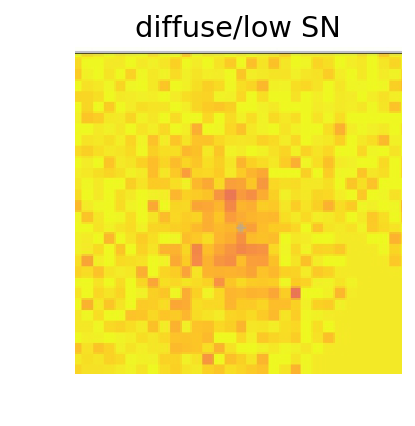

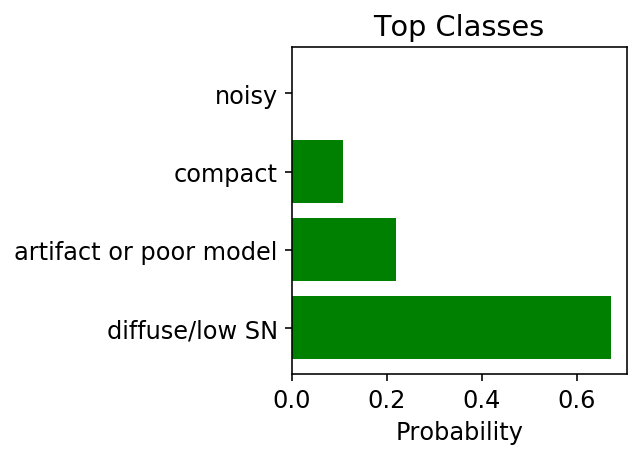

Top Classes:  ['5', '3', '4', '6']
Top Probs:  tensor([[8.6799e-01, 7.8024e-02, 5.3854e-02, 1.2791e-04]])


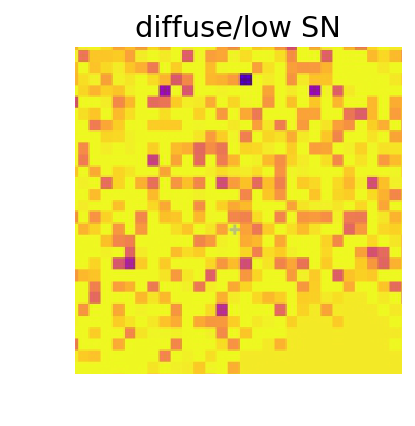

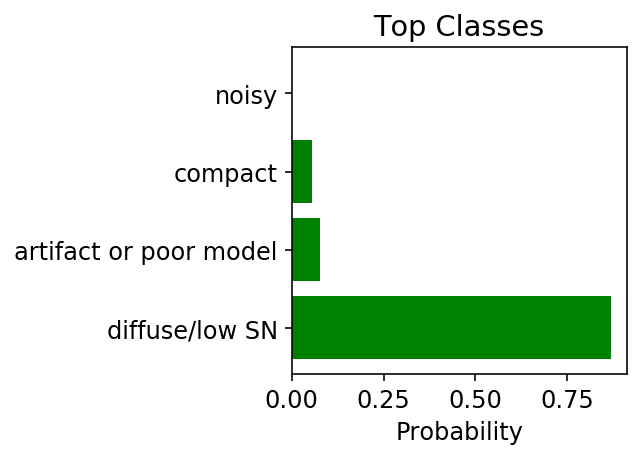

Top Classes:  ['3', '5', '4', '6']
Top Probs:  tensor([[4.8420e-01, 4.0367e-01, 1.1199e-01, 1.3885e-04]])


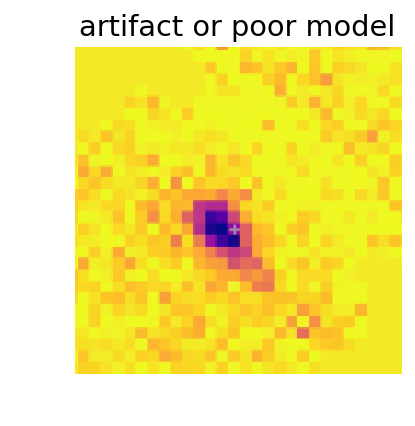

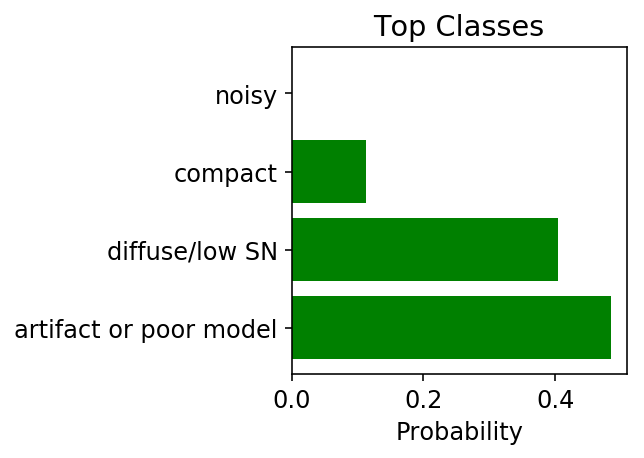

Top Classes:  ['5', '3', '4', '6']
Top Probs:  tensor([[7.5982e-01, 1.7714e-01, 6.3005e-02, 3.1828e-05]])


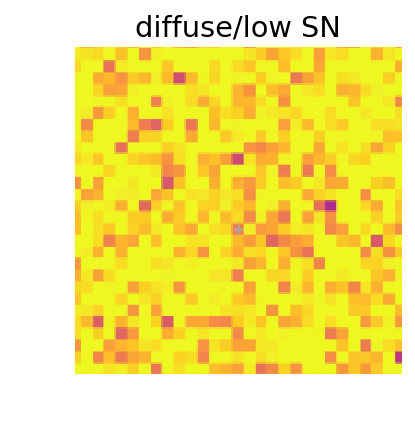

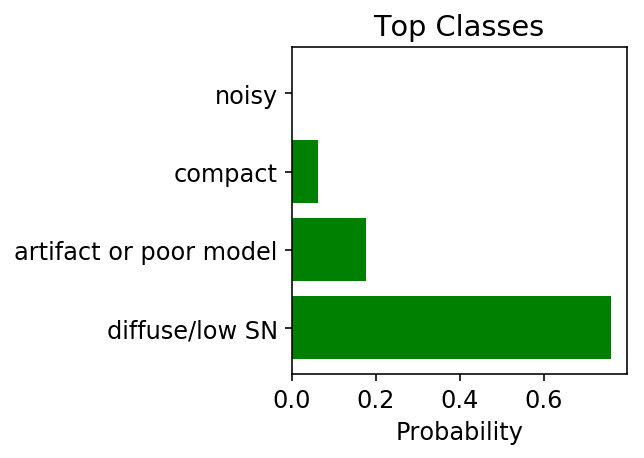

In [133]:
#This can be where the dataset is run on the NN.
#Data needs to be in 3-channel RGB format (jpg). If it is png, run the lines above on the folder. 
def sanity_checking():
    plt.rcParams["figure.figsize"] = (3,3)
    plt.rcParams.update({'font.size': 12})
    directory = '/Users/jennifercooper/Projects/thesis/23.3_mag/all/Extractions/images/single/'
    #directory = '/Users/jennifercooper/Projects/Tesla/PyTorchTraining/pets/dataset_1/'
    for file in os.listdir(directory):
        filename = os.fsdecode(file)
        if filename.endswith("7.line.png.jpg"): 
            image_path = (directory + filename)
            probs, classes = predict(image_path, model)
            image_to_show = process_image(image_path)
            image = imshow(image_to_show.numpy(), ax = plt)
            image.axis('off') #no borders
            image.title(cat_to_name[str(classes[0])])
            image.show()
    
    # Showing Top Classes
            labels = []
            for class_index in classes:
                labels.append(cat_to_name[str(class_index)])
            y_pos = np.arange(len(labels))
            probs = probs[0]

            plt.barh(y_pos, probs, align='center', color='green')
            plt.yticks(y_pos, labels)
            plt.xlabel('Probability')
            plt.title('Top Classes')

            plt.show()
            
            continue
        else:
            continue

sanity_checking()